## Data Cleaning

Using a test run dataset, I show how json data was extracted and converted into read dataframes

In [30]:
import json
import pandas as pd

In [31]:
with open('data/test-run-4.json', 'r') as file:
    data = json.load(file)

In [32]:
data

[{'number_of_runs': 2, 'number_of_simulation_iterations': 500},
 {'final_bankroll': 40,
  'rounds_played': 5,
  'initial_bankroll': 100,
  'round_outcomes': [-5, -5, -10, -10, -5],
  'node_statistics': [[{'hand': ['J', '6', '6'],
     'action': 'hit',
     'action_history': ['hit'],
     'player_value': 16,
     'dealer_upcard': '6',
     'final_dealer_hand': ['6', '8', '3'],
     'final_dealer_value': 17}],
   [{'hand': ['6', '8', '5', '8'],
     'action': 'hit',
     'action_history': ['hit'],
     'player_value': 14,
     'dealer_upcard': '9',
     'final_dealer_hand': ['9', '4', 'K'],
     'final_dealer_value': 23},
    {'hand': ['6', '8', '5', '8'],
     'action': 'hit',
     'action_history': ['hit', 'hit'],
     'player_value': 19,
     'dealer_upcard': '9',
     'final_dealer_hand': ['9', '4', 'K'],
     'final_dealer_value': 23}],
   [{'hand': ['2', '8'],
     'action': 'split',
     'action_history': ['split'],
     'player_value': 4,
     'dealer_upcard': 'Q',
     'final_de

In [33]:
df = pd.read_json('data/test-run-4.json')
df

,number_of_runs,number_of_simulation_iterations,final_bankroll,rounds_played,initial_bankroll,round_outcomes,node_statistics
0,2.0,500.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,40.0,5.0,100.0,"[-5, -5, -10, -10, -5]","[[{'hand': ['J', '6', '6'], 'action': 'hit', '..."
2,NaN,NaN,70.0,5.0,100.0,"[-5, -10, 20, -5, -5]","[[{'hand': ['3', '9', 'J'], 'action': 'hit', '..."


In [34]:
metadata = df[['number_of_runs', 'number_of_simulation_iterations']].dropna()
metadata

,number_of_runs,number_of_simulation_iterations
0,2.0,500.0


In [35]:
final_results = df[['final_bankroll', 'rounds_played', 'initial_bankroll']].dropna()
final_results

,final_bankroll,rounds_played,initial_bankroll
1,40.0,5.0,100.0
2,70.0,5.0,100.0


In [36]:
game_data = df[['round_outcomes']].dropna().reset_index(names='game')

# Explode the 'round_outcomes' column to separate each outcome into its own row
game_data = game_data.explode('round_outcomes').reset_index(drop=True)

# Add round numbers for each game
game_data['round'] = game_data.groupby('game').cumcount() + 1

game_data


,game,round_outcomes,round
0,1,-5,1
1,1,-5,2
2,1,-10,3
3,1,-10,4
4,1,-5,5
5,2,-5,1
6,2,-10,2
7,2,20,3
8,2,-5,4
9,2,-5,5


In [ ]:
node_statistics = []
for game_index, game_nodes in enumerate(df['node_statistics'].dropna()):
    for round_index, round_nodes in enumerate(game_nodes):
        for node in round_nodes:
            #our stats data collects the final agents hand for each round so we want to retrieve state value by using the num of actions in action history
            if 'split_right'in node['action_history'] or 'split_left' in node['action_history']: #splits record 2 actions within the same hand in our game engine logic but we want to treat each action for every hand as an individual state
                node_statistics.append({
                    'game': game_index,
                    'round': round_index + 1,
                    'state': len(node['action_history']) - 1,
                    'hand': node['hand'][:len(node['action_history'])],
                    'action': node['action'],
                    'action_history': node['action_history'],
                    'player_value': node['player_value'],
                    'dealer_upcard': node['dealer_upcard'],
                    'final_dealer_hand': node['final_dealer_hand'],
                    'final_dealer_value': node['final_dealer_value']
                })
            else:
                node_statistics.append({
                    'game': game_index,
                    'round': round_index + 1,
                    'state': len(node['action_history']),
                    'hand': node['hand'][:len(node['action_history']) + 1],
                    'action': node['action'],
                    'action_history': node['action_history'],
                    'player_value': node['player_value'],
                    'dealer_upcard': node['dealer_upcard'],
                    'final_dealer_hand': node['final_dealer_hand'],
                    'final_dealer_value': node['final_dealer_value']
                })

node_statistics_df = pd.DataFrame(node_statistics)

node_statistics_df

,game,round,state,hand,action,action_history,player_value,dealer_upcard,final_dealer_hand,final_dealer_value
0,0,1,1,"[J, 6]",hit,[hit],16,6,"[6, 8, 3]",17
1,0,2,1,"[6, 8]",hit,[hit],14,9,"[9, 4, K]",23
2,0,2,2,"[6, 8, 5]",hit,"[hit, hit]",19,9,"[9, 4, K]",23
3,0,3,1,"[2, 8]",split,[split],4,Q,"[Q, 7]",17
4,0,3,2,"[2, 4, 7]",hit,"[split, split_right, hit]",6,Q,"[Q, 7]",17
5,0,3,3,"[2, 4, 7, 10]",hit,"[split, split_right, hit, hit]",13,Q,"[Q, 7]",17
6,0,3,2,"[2, 8]",stand,"[split, split_left, stand]",10,Q,"[Q, 7]",17
7,0,4,1,"[J, K]",double,[double],20,5,"[5, A, Q, 5]",21
8,0,5,1,"[5, 4]",hit,[hit],9,9,"[9, 10]",19
9,0,5,2,"[5, 4, 3]",hit,"[hit, hit]",12,9,"[9, 10]",19


## Exploratory Analysis

In [38]:
import matplotlib.pyplot as plt

[]

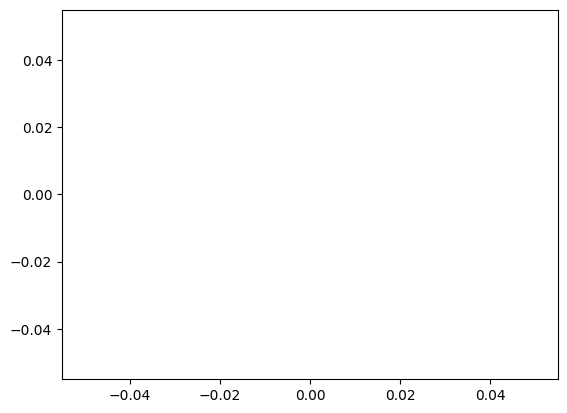

In [39]:
plt.plot()